In [16]:
DATA_PATH = '../Data/Distribution'
import os
import sys
import polars as pl
import numpy as np
import scipy.stats as stats
import tqdm as tqdm
import cython as cy
import importlib

# Load helper functions from Global Directory
sys.path.append('../Global')
from agents import FullInfoAgent
from auction_env import simulate_auction_synchronous, train_agents_synchronous, AuctionEnvironment

In [35]:
import numpy as np
import random
import tqdm

class NoInfoAgent:
    def __init__(self, num_states, num_actions, learning_rate, discount_factor):
        self.q_table = np.zeros((num_states, num_actions))  # Discretized state-action pairs
        self.num_actions = num_actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

    def choose_action(self, state, epsilon):
        if random.random() < epsilon:
            return random.randint(0, self.num_actions - 1)
        else:
            return np.argmax(self.q_table[state])

    def update_q_table(self, state, action, reward, next_state):
        best_next_action = np.argmax(self.q_table[next_state])
        self.q_table[state, action] += self.learning_rate * (
            reward + self.discount_factor * self.q_table[next_state, best_next_action] - self.q_table[state, action])

class AuctionEnvironment:
    def __init__(self, num_agents, num_states):
        self.num_agents = num_agents
        self.num_states = num_states

    def get_types(self):
        return np.random.randint(0, self.num_states, size=self.num_agents)

    def determine_payouts(self, bids):
        payouts = np.zeros(self.num_agents)
        for i in range(self.num_agents):
            for j in range(i + 1, self.num_agents):
                if bids[i] > bids[j]:
                    payouts[i] += bids[j]
                elif bids[j] > bids[i]:
                    payouts[j] += bids[i]
        return payouts

def simulate_auction(agents, env, epsilon):
    types = env.get_types()
    actions = [agent.choose_action(type_, epsilon) for agent, type_ in zip(agents, types)]
    payouts = env.determine_payouts(actions)
    rewards = [type_ - payout if payout > 0 else -type_ for type_, payout in zip(types, payouts)]
    for agent, type_, action, reward, payout in zip(agents, types, actions, rewards, payouts):
        agent.update_q_table(type_, action, reward, type_)  # Stateless, next_state = current_state
    return types, actions, rewards, payouts

def train_agents(num_epochs, num_episodes, agents, env, epsilon):
    results = []
    for epoch in tqdm.tqdm(range(num_epochs), desc='Epoch Progress'):
        for episode in tqdm.tqdm(range(num_episodes), desc='Episode Progress', leave=False):
            result = simulate_auction(agents, env, epsilon)
            results.append([epoch, episode] + list(result))
    return results


Epoch Progress: 100%|██████████| 1000/1000 [4:30:58<00:00, 16.26s/it]     


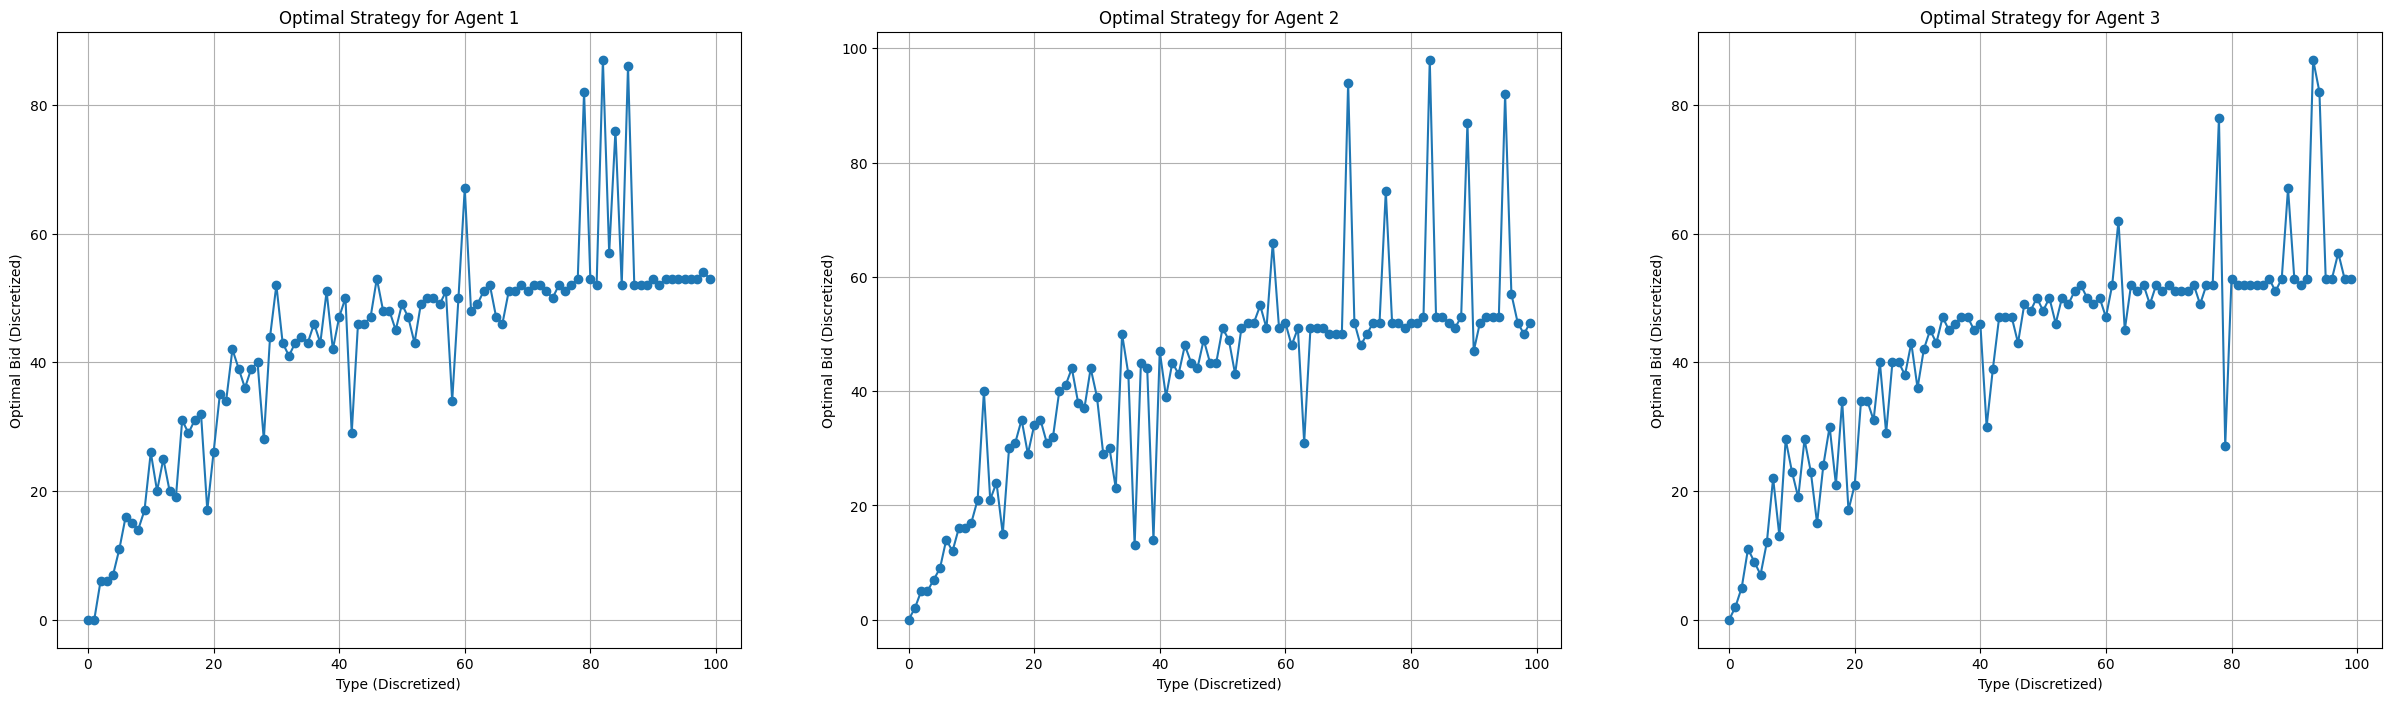

In [38]:
import matplotlib.pyplot as plt

num_agents = 3
num_states = 100 
num_actions = 100  
learning_rate = 0.05
discount_factor = 0.95
epsilon = 0.1
num_epochs = 1000
num_episodes = 10000

agents = [NoInfoAgent(num_states, num_actions, learning_rate, discount_factor) for _ in range(num_agents)]
env = AuctionEnvironment(num_agents, num_states)

# Function to run the training and collect data
training_data = train_agents(num_epochs, num_episodes, agents, env, epsilon)

# Function to plot the optimal strategy from Q-tables
def plot_optimal_strategy(agents):
    fig, axes = plt.subplots(1, len(agents), figsize=(10 * len(agents), 8))
    if len(agents) == 1:
        axes = [axes]  # Make it iterable if only one agent
    for idx, agent in enumerate(agents):
        optimal_strategy = np.argmax(agent.q_table, axis=1)
        axes[idx].plot(optimal_strategy, marker='o', linestyle='-')
        axes[idx].set_title(f'Optimal Strategy for Agent {idx+1}')
        axes[idx].set_xlabel('Type (Discretized)')
        axes[idx].set_ylabel('Optimal Bid (Discretized)')
        axes[idx].grid(True)
    plt.show()

# Run the function to plot the Q-table results
plot_optimal_strategy(agents)


Smoothing Q-table for Agent 1


Smoothing Q-table: 100%|██████████| 100/100 [06:39<00:00,  4.00s/it]


Smoothing Q-table for Agent 2


Smoothing Q-table: 100%|██████████| 100/100 [06:39<00:00,  4.00s/it]


Smoothing Q-table for Agent 3


Smoothing Q-table: 100%|██████████| 100/100 [06:44<00:00,  4.05s/it]


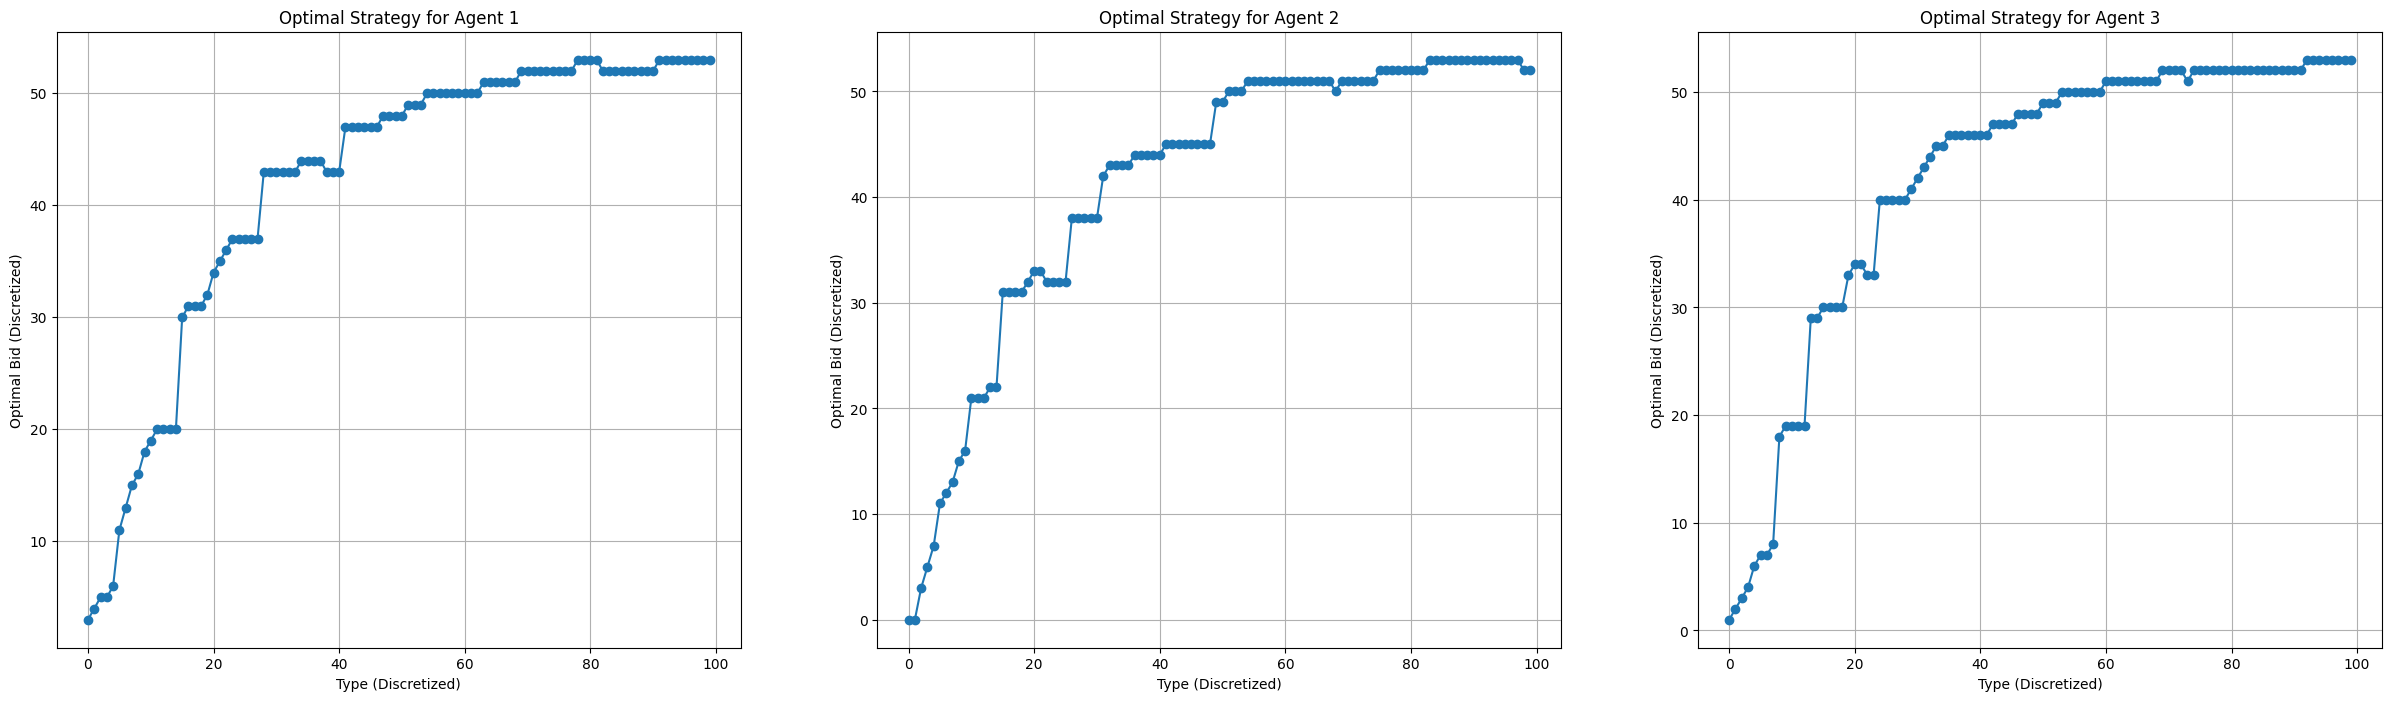

In [42]:
def gaussian_kernel(distance, bandwidth):
    return (1 / (bandwidth * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((distance / bandwidth) ** 2))

import numpy as np

import numpy as np
from tqdm import tqdm

def smooth_q_table(q_table, bandwidth):
    num_states, num_actions = q_table.shape
    smoothed_q_table = np.zeros_like(q_table)
    
    # Use tqdm to track progress on the outer loop
    for i in tqdm(range(num_states), desc='Smoothing Q-table'):
        for j in range(num_actions):
            weighted_sum = 0
            weight_sum = 0
            # Sum over all state-action pairs
            for k in range(num_states):
                for l in range(num_actions):
                    distance = np.sqrt((i - k)**2 + (j - l)**2)
                    weight = np.exp(-0.5 * (distance / bandwidth)**2)
                    weighted_sum += weight * q_table[k, l]
                    weight_sum += weight
            smoothed_q_table[i, j] = weighted_sum / weight_sum if weight_sum != 0 else 0

    return smoothed_q_table

# Apply the smoothing function to each agent's Q-table with tqdm progress
bandwidth = 2.0  # Example bandwidth, adjust as needed
for agent in agents:
    print(f"Smoothing Q-table for Agent {agents.index(agent) + 1}")
    agent.q_table = smooth_q_table(agent.q_table, bandwidth)

# Now, plot the smoothed optimal strategy
plot_optimal_strategy(agents)

